<a href="https://colab.research.google.com/github/takashi4488/rabbit_challenge/blob/main/Day2%E3%83%AC%E3%83%9D%E3%83%BC%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Google Colab 用の処理

下記を実行します
- ドライブのマウント
- ノートブックファイルと同じフォルダへの移動

Googleドライブのマイドライブ を基準に DNN_code/DNN_code_colab_day2 フォルダを置くことを仮定しています。必要に応じて，パスを変更してください．

In [1]:
# Google Colab での実行かを調べる
import sys
import os
ENV_COLAB = True  if 'google.colab' in sys.modules else False

# google drive のマウント
if ENV_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ML-E検定/DNN_code_colab_day2_ver2/DNN_code_colab_day2/notebook')

Mounted at /content/drive


In [2]:
import sys
ENV_COLAB = True if 'google.colab' in sys.modules else False

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

# MNISTデータの読み込み（Keras使用）


In [17]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
d_train = to_categorical(d_train, 10)
d_test = to_categorical(d_test, 10)

# 活性化関数・レイヤークラス


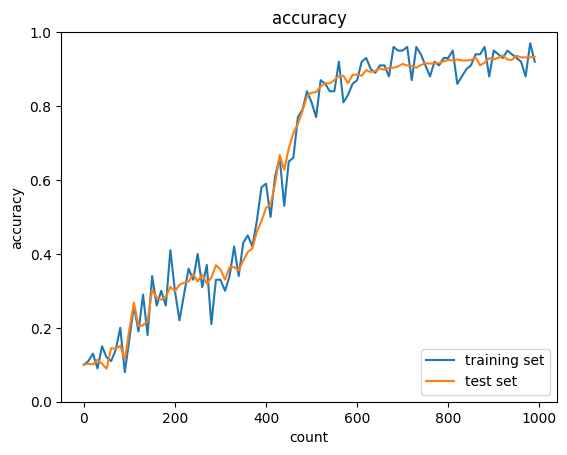

In [18]:
# 活性化関数
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(x.dtype)

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# MultiLayerNetクラス
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std=0.01, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_batchnorm = use_batchnorm
        self.params = {}

        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_grad = sigmoid_grad
        else:
            self.activation = relu
            self.activation_grad = relu_grad

        # 重みの初期化
        all_size_list = [input_size] + hidden_size_list + [output_size]
        for idx in range(1, len(all_size_list)):
            self.params['W' + str(idx)] = weight_init_std * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

        # Batch Normalization用パラメータ
        if use_batchnorm:
            for idx in range(1, self.hidden_layer_num + 1):
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])

    def predict(self, x, train_flg=False):
        self.a = {}
        self.z = {}
        self.z[0] = x

        for idx in range(1, self.hidden_layer_num + 1):
            self.a[idx] = np.dot(self.z[idx-1], self.params['W' + str(idx)]) + self.params['b' + str(idx)]
            self.z[idx] = self.activation(self.a[idx])

        idx = self.hidden_layer_num + 1
        self.a[idx] = np.dot(self.z[idx-1], self.params['W' + str(idx)]) + self.params['b' + str(idx)]
        y = softmax(self.a[idx])
        return y

    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        batch_num = x.shape[0]
        grads = {}

        idx = self.hidden_layer_num + 1
        y = softmax(self.a[idx])
        dy = (y - t) / batch_num

        grads['W' + str(idx)] = np.dot(self.z[idx-1].T, dy)
        grads['b' + str(idx)] = np.sum(dy, axis=0)

        da = np.dot(dy, self.params['W' + str(idx)].T)

        for idx in range(self.hidden_layer_num, 0, -1):
            dz = da * self.activation_grad(self.a[idx])
            grads['W' + str(idx)] = np.dot(self.z[idx-1].T, dz)
            grads['b' + str(idx)] = np.sum(dz, axis=0)
            da = np.dot(dz, self.params['W' + str(idx)].T)

        return grads

# 学習
use_batchnorm = False
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std=0.01, use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.3
momentum = 0.9

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)

    if i == 0:
        v = {}

    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            v[key] = np.zeros_like(network.params[key])
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

# プロット
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#sigmoid - gauss
###活性化関数：シグモイド
###重みの初期値：ガウス分布から生成

Generation: 10. 正答率(トレーニング) = 0.2100, 正答率(テスト) = 0.1028
Generation: 20. 正答率(トレーニング) = 0.1200, 正答率(テスト) = 0.1028
Generation: 30. 正答率(トレーニング) = 0.1000, 正答率(テスト) = 0.0974
Generation: 40. 正答率(トレーニング) = 0.1300, 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.1200, 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.0600, 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.0900, 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.0500, 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.1300, 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.1000, 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.1100, 正答率(テスト) = 0.1028
Generation: 120. 正答率(トレーニング) = 0.1500, 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.0900, 正答率(テスト) = 0.1135
Generation: 140. 正答率(トレーニング) = 0.1400, 正答率(テスト) = 0.1010
Generation: 150. 正答率(トレーニング) = 0.1200, 正答率(テスト) = 0.1135
Generation: 160. 正答率(トレーニング) = 0.1300, 正答率(テスト) = 0.1010
Generation: 170. 正答率(トレーニング) = 0.1800, 正答率(テスト) = 0.1135
Generation: 180. 正答率(トレーニング) = 0.1500, 正

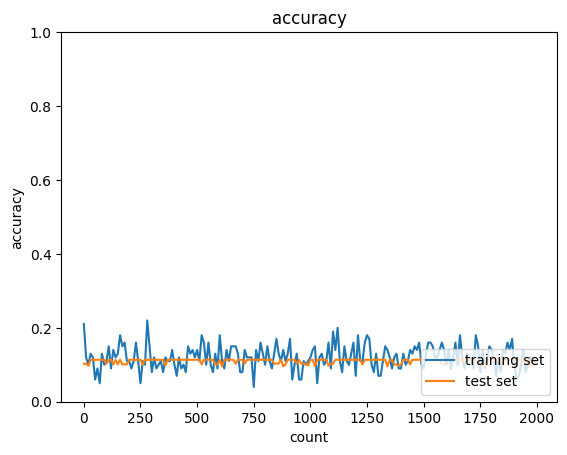

In [19]:
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新（層数に依存しない）
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print(f'Generation: {i+1}. 正答率(トレーニング) = {accr_train:.4f}, 正答率(テスト) = {accr_test:.4f}')

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#隠れ層のサイズを変えてみる
###[40, 20] → [20, 10]に変更

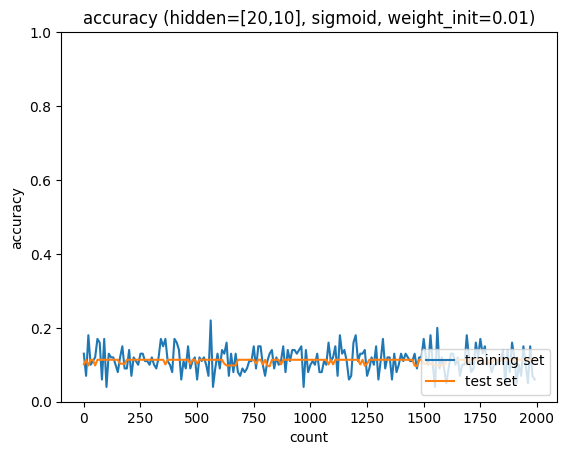

最終精度 - トレーニング: 0.0600, テスト: 0.1135


In [20]:
network = MultiLayerNet(input_size=784, hidden_size_list=[20, 10], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新（層数に依存しない）
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (hidden=[20,10], sigmoid, weight_init=0.01)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

# 最終結果
print(f"最終精度 - トレーニング: {accuracies_train[-1]:.4f}, テスト: {accuracies_test[-1]:.4f}")

###結果変わらず

#ReLU - gauss
###活性化関数：ReLU
###重みの初期値：ガウス分布から生成

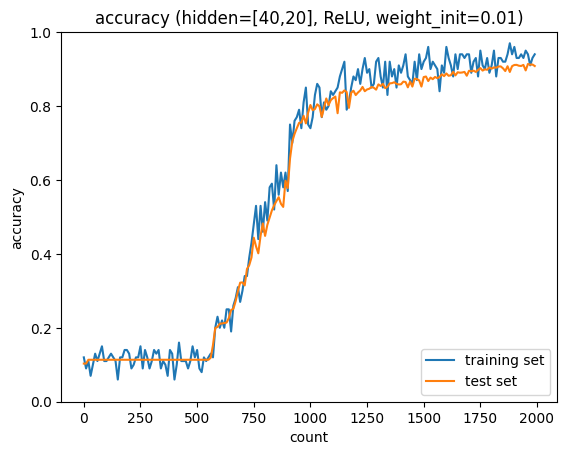

最終精度 - トレーニング: 0.9400, テスト: 0.9083


In [21]:
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (hidden=[40,20], ReLU, weight_init=0.01)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

# 最終結果
print(f"最終精度 - トレーニング: {accuracies_train[-1]:.4f}, テスト: {accuracies_test[-1]:.4f}")

#sigmoid - Xavier

In [25]:
class MultiLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size_list: 隠れ層のノード数のリスト
    output_size: 出力層のノード数
    activation: 活性化関数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()

        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]

        for idx in range(1, len(all_size_list)):
            # 初期化方法の判定
            if isinstance(weight_init_std, str):
                if weight_init_std.lower() in ('relu', 'he'):
                    scale = np.sqrt(2.0 / all_size_list[idx - 1])
                elif weight_init_std.lower() in ('sigmoid', 'xavier'):
                    scale = np.sqrt(1.0 / all_size_list[idx - 1])
                else:
                    scale = 0.01  # デフォルト
            else:
                scale = weight_init_std

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if d.ndim != 1:
            d = np.argmax(d, axis=1)
        accuracy = np.sum(y == d) / float(x.shape[0])
        return accuracy

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grad['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grad['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grad

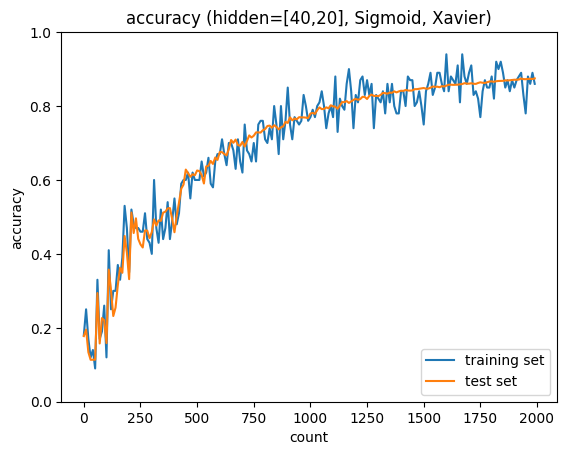

最終精度 - トレーニング: 0.8600, テスト: 0.8747


In [27]:
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (hidden=[40,20], Sigmoid, Xavier)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

# 最終結果
print(f"最終精度 - トレーニング: {accuracies_train[-1]:.4f}, テスト: {accuracies_test[-1]:.4f}")

#ReLU - He
###活性化関数：ReLU
###重みの初期値：Heの初期値を使用

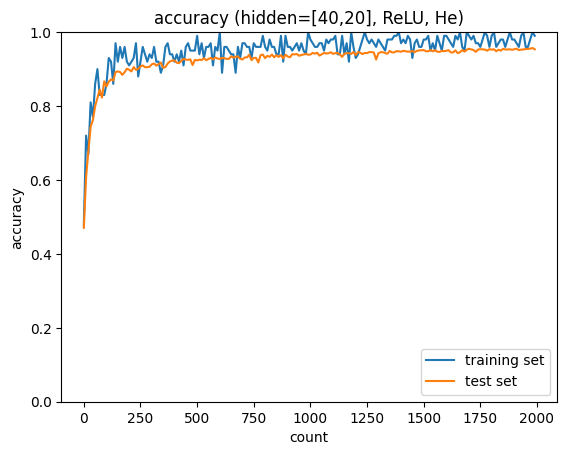

最終精度 - トレーニング: 0.9900, テスト: 0.9534


In [28]:
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (hidden=[40,20], ReLU, He)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

# 最終結果
print(f"最終精度 - トレーニング: {accuracies_train[-1]:.4f}, テスト: {accuracies_test[-1]:.4f}")

###改善が見られた

#Section 2 学習率最適化手法について

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
d_train = to_categorical(d_train, 10)
d_test = to_categorical(d_test, 10)

#Momentum

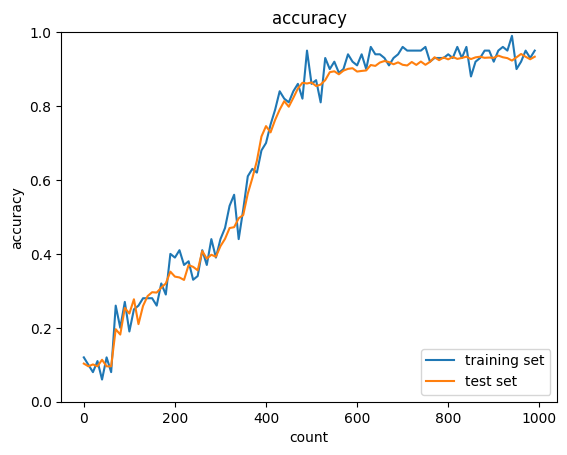

In [30]:
# 活性化関数
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(x.dtype)

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# MultiLayerNetクラス
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std=0.01, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_batchnorm = use_batchnorm
        self.params = {}

        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_grad = sigmoid_grad
        else:
            self.activation = relu
            self.activation_grad = relu_grad

        # 重みの初期化
        all_size_list = [input_size] + hidden_size_list + [output_size]
        for idx in range(1, len(all_size_list)):
            self.params['W' + str(idx)] = weight_init_std * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

        # Batch Normalization用パラメータ
        if use_batchnorm:
            for idx in range(1, self.hidden_layer_num + 1):
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])

    def predict(self, x, train_flg=False):
        self.a = {}
        self.z = {}
        self.z[0] = x

        for idx in range(1, self.hidden_layer_num + 1):
            self.a[idx] = np.dot(self.z[idx-1], self.params['W' + str(idx)]) + self.params['b' + str(idx)]
            self.z[idx] = self.activation(self.a[idx])

        idx = self.hidden_layer_num + 1
        self.a[idx] = np.dot(self.z[idx-1], self.params['W' + str(idx)]) + self.params['b' + str(idx)]
        y = softmax(self.a[idx])
        return y

    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        batch_num = x.shape[0]
        grads = {}

        idx = self.hidden_layer_num + 1
        y = softmax(self.a[idx])
        dy = (y - t) / batch_num

        grads['W' + str(idx)] = np.dot(self.z[idx-1].T, dy)
        grads['b' + str(idx)] = np.sum(dy, axis=0)

        da = np.dot(dy, self.params['W' + str(idx)].T)

        for idx in range(self.hidden_layer_num, 0, -1):
            dz = da * self.activation_grad(self.a[idx])
            grads['W' + str(idx)] = np.dot(self.z[idx-1].T, dz)
            grads['b' + str(idx)] = np.sum(dz, axis=0)
            da = np.dot(dz, self.params['W' + str(idx)].T)

        return grads

# 学習
use_batchnorm = False
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std=0.01, use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.3
momentum = 0.9

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)

    if i == 0:
        v = {}

    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            v[key] = np.zeros_like(network.params[key])
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

# プロット
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#AdaGrad

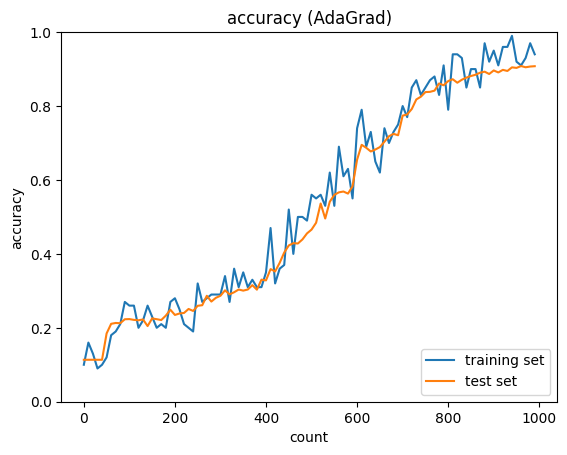

In [31]:
# AdaGrad検証
# batch_normalizationの設定 =======================
use_batchnorm = False
# ====================================================
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std=0.01, use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)

    if i == 0:
        h = {}

    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        # AdaGrad ###############
        if i == 0:
            h[key] = np.full_like(network.params[key], 1e-4)
        else:
            h[key] += np.square(grad[key])
        network.params[key] -= learning_rate * grad[key] / (np.sqrt(h[key]))
        ##########################

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (AdaGrad)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#RMSProp

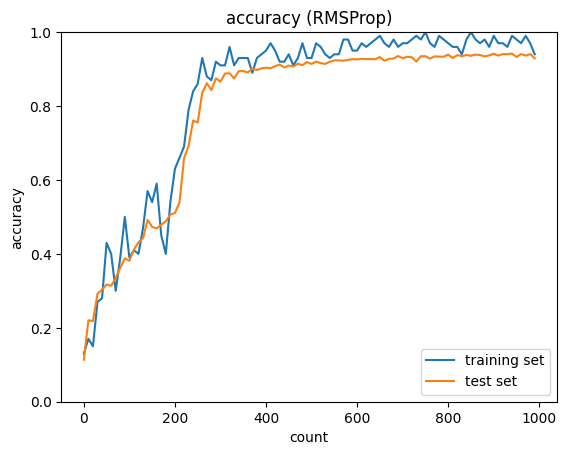

In [32]:
# RMSProp検証
use_batchnorm = False
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std=0.01, use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
decay_rate = 0.99

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)

    if i == 0:
        h = {}

    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        # RMSProp ##################
        if i == 0:
            h[key] = np.zeros_like(network.params[key])
        h[key] *= decay_rate
        h[key] += (1 - decay_rate) * np.square(grad[key])
        network.params[key] -= learning_rate * grad[key] / (np.sqrt(h[key]) + 1e-7)
        ############################

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (RMSProp)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#Adam

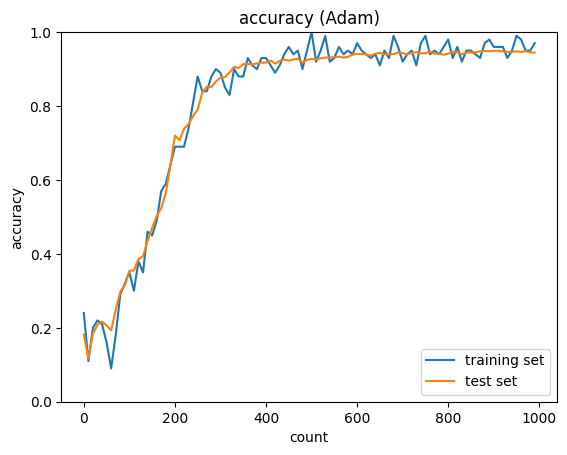

In [33]:
# Adam検証
use_batchnorm = False
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std=0.01, use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)

    if i == 0:
        m = {}
        v = {}

    learning_rate_t = learning_rate * np.sqrt(1.0 - beta2 ** (i + 1)) / (1.0 - beta1 ** (i + 1))

    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        # Adam ##############
        if i == 0:
            m[key] = np.zeros_like(network.params[key])
            v[key] = np.zeros_like(network.params[key])
        m[key] += (1 - beta1) * (grad[key] - m[key])
        v[key] += (1 - beta2) * (grad[key] ** 2 - v[key])
        network.params[key] -= learning_rate_t * m[key] / (np.sqrt(v[key]) + 1e-7)
        #####################

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (Adam)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#Section3  過学習
#正則化なし

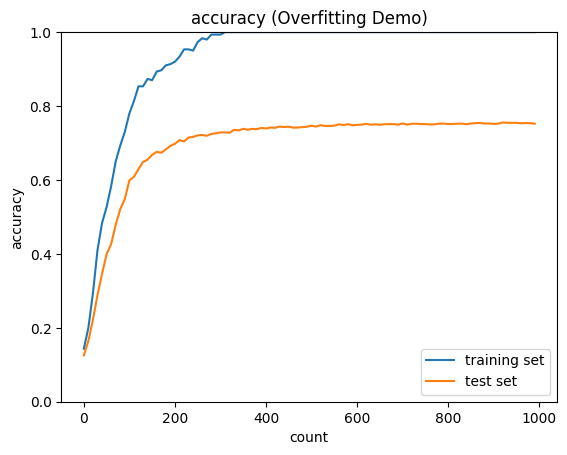

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# SGDオプティマイザ
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, params, grads):
        for key in params.keys():
            if key in grads:
                params[key] -= self.learning_rate * grads[key]

# 深い層のMultiLayerNet（6層）
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size, weight_init_std=0.01):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # 重みの初期化（He初期化）
        all_size_list = [input_size] + hidden_size_list + [output_size]
        for idx in range(1, len(all_size_list)):
            scale = np.sqrt(2.0 / all_size_list[idx-1])  # He初期化
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        self.a = {}
        self.z = {}
        self.z[0] = x

        for idx in range(1, self.hidden_layer_num + 1):
            self.a[idx] = np.dot(self.z[idx-1], self.params['W' + str(idx)]) + self.params['b' + str(idx)]
            self.z[idx] = np.maximum(0, self.a[idx])  # ReLU

        idx = self.hidden_layer_num + 1
        self.a[idx] = np.dot(self.z[idx-1], self.params['W' + str(idx)]) + self.params['b' + str(idx)]

        # softmax
        x_out = self.a[idx]
        x_out = x_out - np.max(x_out, axis=-1, keepdims=True)
        y = np.exp(x_out) / np.sum(np.exp(x_out), axis=-1, keepdims=True)
        return y

    def loss(self, x, t):
        y = self.predict(x)
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        self.loss(x, t)

        batch_num = x.shape[0]
        grads = {}

        idx = self.hidden_layer_num + 1
        y = self.predict(x)
        dy = y.copy()
        dy[np.arange(batch_num), t] -= 1
        dy /= batch_num

        grads['W' + str(idx)] = np.dot(self.z[idx-1].T, dy)
        grads['b' + str(idx)] = np.sum(dy, axis=0)
        da = np.dot(dy, self.params['W' + str(idx)].T)

        for idx in range(self.hidden_layer_num, 0, -1):
            dz = da * (self.a[idx] > 0)  # ReLU微分
            grads['W' + str(idx)] = np.dot(self.z[idx-1].T, dz)
            grads['b' + str(idx)] = np.sum(dz, axis=0)
            da = np.dot(dz, self.params['W' + str(idx)].T)

        return grads

# 学習
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(learning_rate=0.01)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (Overfitting Demo)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#L2正則化

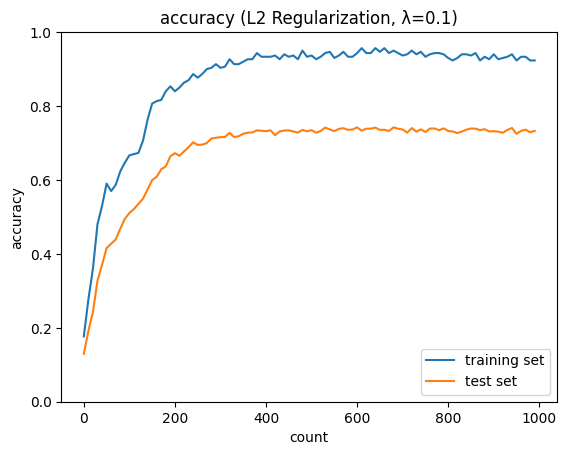

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# MultiLayerNet（layers属性付き）
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}
        self.layers = {}

        # 重みの初期化（He初期化）
        all_size_list = [input_size] + hidden_size_list + [output_size]
        for idx in range(1, len(all_size_list)):
            scale = np.sqrt(2.0 / all_size_list[idx-1])
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

    def predict(self, x):
        a = x
        for idx in range(1, self.hidden_layer_num + 1):
            a = self.layers['Affine' + str(idx)].forward(a)
            a = np.maximum(0, a)  # ReLU

        idx = self.hidden_layer_num + 1
        a = self.layers['Affine' + str(idx)].forward(a)

        # softmax
        a = a - np.max(a, axis=-1, keepdims=True)
        y = np.exp(a) / np.sum(np.exp(a), axis=-1, keepdims=True)
        return y

    def loss(self, x, t):
        y = self.predict(x)
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        batch_num = x.shape[0]

        # backward
        y = self.predict(x)
        dy = y.copy()
        dy[np.arange(batch_num), t] -= 1
        dy /= batch_num

        # 各層を逆順に
        layers_list = list(range(1, self.hidden_layer_num + 2))
        layers_list.reverse()

        da = dy
        for idx in layers_list:
            da = self.layers['Affine' + str(idx)].backward(da)
            if idx > 1:
                # ReLU微分（前の層の出力に対して）
                da = da * (self.layers['Affine' + str(idx-1)].out > 0)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

# Affineレイヤ
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.out = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        self.out = np.dot(x, self.W) + self.b
        return self.out

    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        return dx

# 学習（L2正則化付き）
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

hidden_layer_num = network.hidden_layer_num

# 正則化強度設定
weight_decay_lambda = 0.1

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)

    weight_decay = 0
    for idx in range(1, hidden_layer_num + 2):  # 出力層も含める
        # L2正則化の勾配を追加
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * network.params['W' + str(idx)]
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db

        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]

        # Affineレイヤの参照も更新
        network.layers['Affine' + str(idx)].W = network.params['W' + str(idx)]
        network.layers['Affine' + str(idx)].b = network.params['b' + str(idx)]

        # L2ノルムの計算
        weight_decay += 0.5 * weight_decay_lambda * np.sum(network.params['W' + str(idx)] ** 2)

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (L2 Regularization, λ=0.1)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#L1正則化

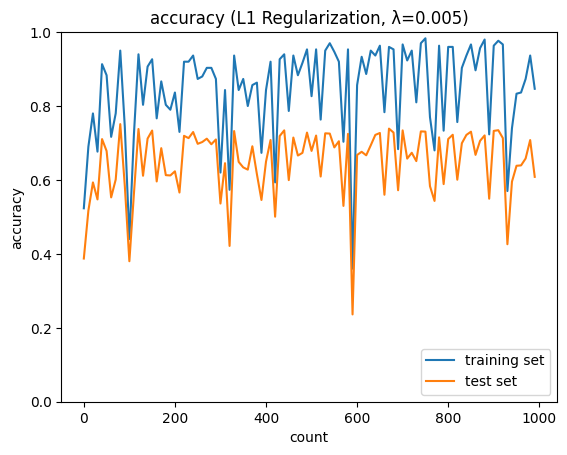

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# Affineレイヤ
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.out = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        self.out = np.dot(x, self.W) + self.b
        return self.out

    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        return dx

# MultiLayerNet
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}
        self.layers = {}

        all_size_list = [input_size] + hidden_size_list + [output_size]
        for idx in range(1, len(all_size_list)):
            scale = np.sqrt(2.0 / all_size_list[idx-1])
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

    def predict(self, x):
        a = x
        for idx in range(1, self.hidden_layer_num + 1):
            a = self.layers['Affine' + str(idx)].forward(a)
            a = np.maximum(0, a)  # ReLU
        idx = self.hidden_layer_num + 1
        a = self.layers['Affine' + str(idx)].forward(a)
        a = a - np.max(a, axis=-1, keepdims=True)
        y = np.exp(a) / np.sum(np.exp(a), axis=-1, keepdims=True)
        return y

    def loss(self, x, t):
        y = self.predict(x)
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        self.loss(x, t)
        batch_num = x.shape[0]

        y = self.predict(x)
        dy = y.copy()
        dy[np.arange(batch_num), t] -= 1
        dy /= batch_num

        layers_list = list(range(1, self.hidden_layer_num + 2))
        layers_list.reverse()

        da = dy
        for idx in layers_list:
            da = self.layers['Affine' + str(idx)].backward(da)
            if idx > 1:
                da = da * (self.layers['Affine' + str(idx-1)].out > 0)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
        return grads

# 学習（L1正則化付き）
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

hidden_layer_num = network.hidden_layer_num

# 正則化強度設定
weight_decay_lambda = 0.005

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)

    weight_decay = 0
    for idx in range(1, hidden_layer_num + 2):
        # L1正則化の勾配を追加
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db

        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]

        network.layers['Affine' + str(idx)].W = network.params['W' + str(idx)]
        network.layers['Affine' + str(idx)].b = network.params['b' + str(idx)]

        # L1ノルム
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (L1 Regularization, λ=0.005)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#Dropout

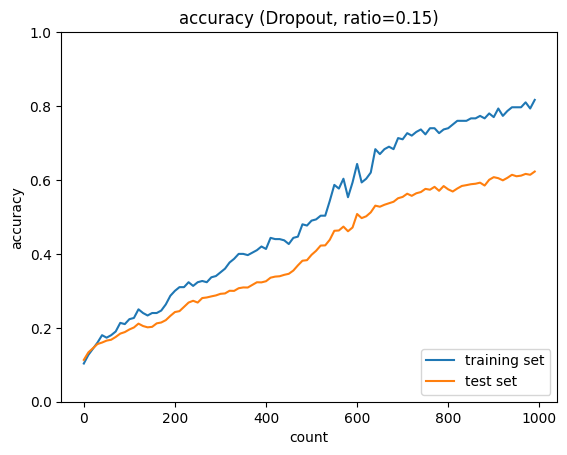

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# Dropoutレイヤ
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

# Affineレイヤ
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.out = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        self.out = np.dot(x, self.W) + self.b
        return self.out

    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        return dx

# ReLUレイヤ
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, dout):
        return dout * self.mask

# SGDオプティマイザ
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, params, grads):
        for key in params.keys():
            if key in grads:
                params[key] -= self.learning_rate * grads[key]

# Dropout対応MultiLayerNet
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size,
                 weight_decay_lambda=0, use_dropout=False, dropout_ratio=0.5):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.use_dropout = use_dropout
        self.params = {}
        self.layers = {}

        all_size_list = [input_size] + hidden_size_list + [output_size]

        for idx in range(1, len(all_size_list)):
            scale = np.sqrt(2.0 / all_size_list[idx-1])
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

        # レイヤの構築
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['ReLU' + str(idx)] = ReLU()
            if use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

    def predict(self, x, train_flg=False):
        for idx in range(1, self.hidden_layer_num + 1):
            x = self.layers['Affine' + str(idx)].forward(x)
            x = self.layers['ReLU' + str(idx)].forward(x)
            if self.use_dropout:
                x = self.layers['Dropout' + str(idx)].forward(x, train_flg)

        idx = self.hidden_layer_num + 1
        x = self.layers['Affine' + str(idx)].forward(x)

        # softmax
        x = x - np.max(x, axis=-1, keepdims=True)
        y = np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
        return y

    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        batch_size = y.shape[0]
        loss = -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

        # Weight decay
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return loss + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        batch_num = x.shape[0]

        # backward
        y = self.predict(x, train_flg=True)
        dy = y.copy()
        dy[np.arange(batch_num), t] -= 1
        dy /= batch_num

        # 出力層
        idx = self.hidden_layer_num + 1
        dy = self.layers['Affine' + str(idx)].backward(dy)

        # 隠れ層（逆順）
        for idx in range(self.hidden_layer_num, 0, -1):
            if self.use_dropout:
                dy = self.layers['Dropout' + str(idx)].backward(dy)
            dy = self.layers['ReLU' + str(idx)].backward(dy)
            dy = self.layers['Affine' + str(idx)].backward(dy)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

# 学習（Dropout付き）
use_dropout = True
dropout_ratio = 0.15
weight_decay_lambda = 0

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda, use_dropout=use_dropout, dropout_ratio=dropout_ratio)
optimizer = SGD(learning_rate=0.01)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    # パラメータ更新後、Affineレイヤの参照も更新
    for idx in range(1, network.hidden_layer_num + 2):
        network.layers['Affine' + str(idx)].W = network.params['W' + str(idx)]
        network.layers['Affine' + str(idx)].b = network.params['b' + str(idx)]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (Dropout, ratio=0.15)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#Section4 畳み込みニューラルネットワークの概念

#image to col, col to image

# CNNの構造:
# Input(1,28,28) -> Conv(30,5x5) -> ReLU -> Pool(2x2) -> Affine(100) -> ReLU -> Affine(10) -> Softmax

Iteration 100: Train=0.1160, Test=0.1260
Iteration 200: Train=0.1160, Test=0.1260
Iteration 300: Train=0.1160, Test=0.1260
Iteration 400: Train=0.1160, Test=0.1260
Iteration 500: Train=0.1160, Test=0.1260
Iteration 600: Train=0.1160, Test=0.1260
Iteration 700: Train=0.1230, Test=0.1310
Iteration 800: Train=0.3040, Test=0.2840
Iteration 900: Train=0.2860, Test=0.3060
Iteration 1000: Train=0.2260, Test=0.2490


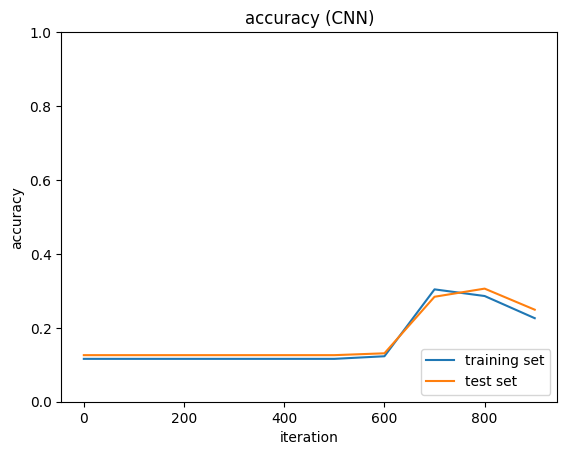

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 1, 28, 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 1, 28, 28).astype('float32') / 255.0

# im2col: 画像データを2次元配列に変換
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3)
    col = col.reshape(N * out_h * out_w, -1)
    return col

# col2im: 2次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    return img[:, :, pad:H + pad, pad:W + pad]

# Convolutionレイヤ
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        self.x = None
        self.col = None
        self.col_W = None
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = (H + 2 * self.pad - FH) // self.stride + 1
        out_w = (W + 2 * self.pad - FW) // self.stride + 1

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

# Poolingレイヤ
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = (H - self.pool_h) // self.stride + 1
        out_w = (W - self.pool_w) // self.stride + 1

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

# ReLU
class ReLU:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask
    def backward(self, dout):
        return dout * self.mask

# Affine
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        return np.dot(x, self.W) + self.b

    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        dx = dx.reshape(*self.original_x_shape)
        return dx

# SoftmaxWithLoss
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        x = x - np.max(x, axis=1, keepdims=True)
        self.y = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        self.loss = -np.sum(np.log(self.y[np.arange(len(t)), t] + 1e-7)) / len(t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx /= batch_size
        return dx

# SimpleConvNet
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) // filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size // 2) * (conv_output_size // 2))

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = {}
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], filter_stride, filter_pad)
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        acc = 0.0
        for i in range(int(np.ceil(x.shape[0] / batch_size))):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)
        return acc / x.shape[0]

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        return grads

# SGD
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

# 学習
network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
optimizer = SGD(lr=0.01)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 100

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    # レイヤのパラメータも更新
    network.layers['Conv1'].W = network.params['W1']
    network.layers['Conv1'].b = network.params['b1']
    network.layers['Affine1'].W = network.params['W2']
    network.layers['Affine1'].b = network.params['b2']
    network.layers['Affine2'].W = network.params['W3']
    network.layers['Affine2'].b = network.params['b3']

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_train = network.accuracy(x_train[:1000], d_train[:1000])
        accr_test = network.accuracy(x_test[:1000], d_test[:1000])
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        print(f'Iteration {i+1}: Train={accr_train:.4f}, Test={accr_test:.4f}')

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (CNN)")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#convolition class

=== Convolutionレイヤの検証 ===

1. 基本動作テスト
   入力形状: (5, 1, 28, 28)
   出力形状: (5, 10, 24, 24)
   期待形状: (5, 10, 24, 24)

2. パディングありのテスト
   入力形状: (5, 1, 28, 28)
   出力形状: (5, 10, 28, 28)

3. ストライド2のテスト
   入力形状: (5, 1, 28, 28)
   出力形状: (5, 10, 12, 12)

4. 勾配計算テスト（backward）
   dout形状: (5, 10, 24, 24)
   dx形状: (5, 1, 28, 28)
   dW形状: (10, 1, 5, 5)
   db形状: (10,)

5. 数値勾配検証
   勾配の差（平均）: 2.24e-13
   検証結果: OK

6. 学習前のフィルター可視化


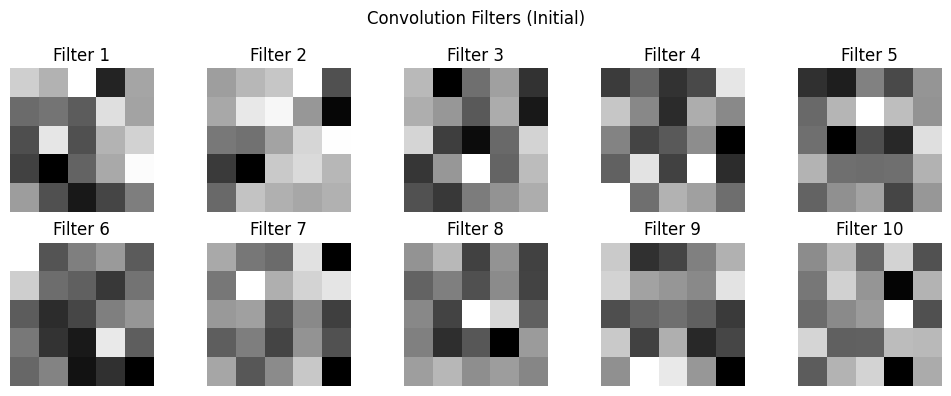


=== 検証完了 ===


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 1, 28, 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 1, 28, 28).astype('float32') / 255.0

# im2col
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3)
    col = col.reshape(N * out_h * out_w, -1)
    return col

# col2im
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    return img[:, :, pad:H + pad, pad:W + pad]

# Convolutionレイヤ
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        self.x = None
        self.col = None
        self.col_W = None
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        self.x = x
        self.col = col
        self.col_W = col_W
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

# ===== Convolutionレイヤの検証 =====
print("=== Convolutionレイヤの検証 ===\n")

# 1. 基本動作テスト
print("1. 基本動作テスト")
W = np.random.randn(10, 1, 5, 5) * 0.01  # 10フィルター, 1チャンネル, 5x5
b = np.zeros(10)
conv = Convolution(W, b, stride=1, pad=0)

x_sample = x_train[:5]  # 5枚の画像
out = conv.forward(x_sample)
print(f"   入力形状: {x_sample.shape}")  # (5, 1, 28, 28)
print(f"   出力形状: {out.shape}")        # (5, 10, 24, 24)
print(f"   期待形状: (5, 10, 24, 24)")
print()

# 2. パディングありのテスト
print("2. パディングありのテスト")
conv_pad = Convolution(W, b, stride=1, pad=2)
out_pad = conv_pad.forward(x_sample)
print(f"   入力形状: {x_sample.shape}")
print(f"   出力形状: {out_pad.shape}")    # (5, 10, 28, 28) - 入力と同じサイズ
print()

# 3. ストライド2のテスト
print("3. ストライド2のテスト")
conv_stride = Convolution(W, b, stride=2, pad=0)
out_stride = conv_stride.forward(x_sample)
print(f"   入力形状: {x_sample.shape}")
print(f"   出力形状: {out_stride.shape}") # (5, 10, 12, 12)
print()

# 4. 勾配計算テスト
print("4. 勾配計算テスト（backward）")
dout = np.random.randn(*out.shape)
dx = conv.backward(dout)
print(f"   dout形状: {dout.shape}")
print(f"   dx形状: {dx.shape}")
print(f"   dW形状: {conv.dW.shape}")
print(f"   db形状: {conv.db.shape}")
print()

# 5. 数値勾配検証
print("5. 数値勾配検証")
def numerical_gradient(f, x, h=1e-4):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp = x[idx]
        x[idx] = tmp + h
        fxh1 = f(x)
        x[idx] = tmp - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp
        it.iternext()
    return grad

# 小さいデータで検証
W_small = np.random.randn(2, 1, 3, 3) * 0.1
b_small = np.zeros(2)
x_small = x_train[:2, :, :10, :10]  # 2枚, 10x10に縮小

conv_test = Convolution(W_small.copy(), b_small.copy(), stride=1, pad=0)

def loss_W(W):
    conv_test.W = W
    out = conv_test.forward(x_small)
    return np.sum(out ** 2)

# 解析的勾配
out = conv_test.forward(x_small)
dout = 2 * out
conv_test.backward(dout)
analytical_grad = conv_test.dW.copy()

# 数値勾配（時間かかるので一部だけ）
numerical_grad = numerical_gradient(loss_W, W_small.copy())

diff = np.abs(analytical_grad - numerical_grad).mean()
print(f"   勾配の差（平均）: {diff:.2e}")
print(f"   検証結果: {'OK' if diff < 1e-4 else 'NG'}")
print()

# 6. フィルターの可視化
print("6. 学習前のフィルター可視化")
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(W[i, 0], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Filter {i+1}')
plt.suptitle('Convolution Filters (Initial)')
plt.tight_layout()
plt.show()

print("\n=== 検証完了 ===")

#pooling class

=== Poolingレイヤの検証 ===

1. 基本動作テスト（2x2, stride=2）
   入力形状: (5, 1, 28, 28)
   出力形状: (5, 1, 14, 14)
   期待形状: (5, 1, 14, 14)

2. 3x3プーリング（stride=3）のテスト
   入力形状: (5, 1, 27, 27)
   出力形状: (5, 1, 9, 9)

3. 手動計算との比較
   入力:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
   出力:
[[ 6.  8.]
 [14. 16.]]
   期待値: [[6, 8], [14, 16]]
   検証: OK

4. backward検証
   dout形状: (5, 1, 14, 14)
   dx形状: (5, 1, 28, 28)
   形状一致: OK

5. 勾配の数値検証
   勾配の差（平均）: 1.44e-04
   検証結果: NG

6. プーリング効果の可視化


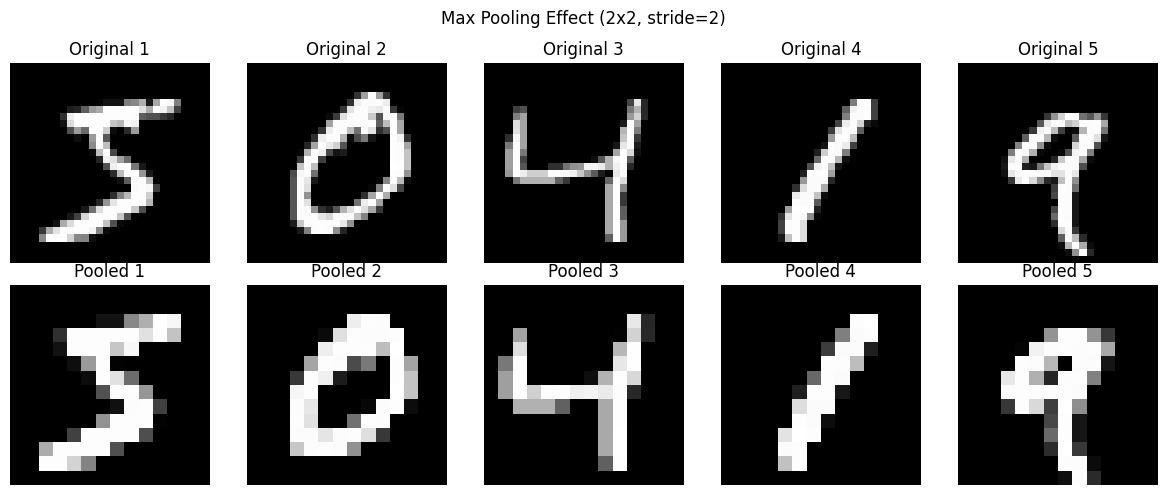


=== 検証完了 ===


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 1, 28, 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 1, 28, 28).astype('float32') / 255.0

# im2col
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3)
    col = col.reshape(N * out_h * out_w, -1)
    return col

# col2im
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    return img[:, :, pad:H + pad, pad:W + pad]

# Poolingレイヤ
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

# ===== Poolingレイヤの検証 =====
print("=== Poolingレイヤの検証 ===\n")

# 1. 基本動作テスト(2x2, stride=2）
print("1. 基本動作テスト（2x2, stride=2）")
pool = Pooling(pool_h=2, pool_w=2, stride=2)
x_sample = x_train[:5]
out = pool.forward(x_sample)
print(f"   入力形状: {x_sample.shape}")  # (5, 1, 28, 28)
print(f"   出力形状: {out.shape}")        # (5, 1, 14, 14)
print(f"   期待形状: (5, 1, 14, 14)")
print()

# 2. 3x3プーリングのテスト
print("2. 3x3プーリング（stride=3）のテスト")
pool_3x3 = Pooling(pool_h=3, pool_w=3, stride=3)
# 27x27にリサイズして使用
x_27 = x_train[:5, :, :27, :27]
out_3x3 = pool_3x3.forward(x_27)
print(f"   入力形状: {x_27.shape}")       # (5, 1, 27, 27)
print(f"   出力形状: {out_3x3.shape}")    # (5, 1, 9, 9)
print()

# 3. 手動計算との比較
print("3. 手動計算との比較")
x_test_small = np.array([[[[1, 2, 3, 4],
                           [5, 6, 7, 8],
                           [9, 10, 11, 12],
                           [13, 14, 15, 16]]]]).astype('float32')
pool_test = Pooling(pool_h=2, pool_w=2, stride=2)
out_test = pool_test.forward(x_test_small)
print(f"   入力:\n{x_test_small[0, 0]}")
print(f"   出力:\n{out_test[0, 0]}")
print(f"   期待値: [[6, 8], [14, 16]]")
expected = np.array([[6, 8], [14, 16]])
print(f"   検証: {'OK' if np.allclose(out_test[0, 0], expected) else 'NG'}")
print()

# 4. backward検証
print("4. backward検証")
dout = np.random.randn(*out.shape)
dx = pool.backward(dout)
print(f"   dout形状: {dout.shape}")
print(f"   dx形状: {dx.shape}")
print(f"   形状一致: {'OK' if dx.shape == x_sample.shape else 'NG'}")
print()

# 5. 勾配の数値検証
print("5. 勾配の数値検証")
x_small = np.random.randn(2, 1, 8, 8).astype('float32')
pool_small = Pooling(pool_h=2, pool_w=2, stride=2)

def loss_func(x):
    out = pool_small.forward(x)
    return np.sum(out ** 2)

# 解析的勾配
out = pool_small.forward(x_small.copy())
dout = 2 * out
analytical_grad = pool_small.backward(dout)

# 数値勾配
h = 1e-4
numerical_grad = np.zeros_like(x_small)
it = np.nditer(x_small, flags=['multi_index'], op_flags=['readwrite'])
while not it.finished:
    idx = it.multi_index
    tmp = x_small[idx]
    x_small[idx] = tmp + h
    fxh1 = loss_func(x_small)
    x_small[idx] = tmp - h
    fxh2 = loss_func(x_small)
    numerical_grad[idx] = (fxh1 - fxh2) / (2 * h)
    x_small[idx] = tmp
    it.iternext()

diff = np.abs(analytical_grad - numerical_grad).mean()
print(f"   勾配の差（平均）: {diff:.2e}")
print(f"   検証結果: {'OK' if diff < 1e-4 else 'NG'}")
print()

# 6. プーリング効果の可視化
print("6. プーリング効果の可視化")

# Poolingを再度適用
pool_vis = Pooling(pool_h=2, pool_w=2, stride=2)
x_vis = x_train[:5]  # 5枚の画像
out_vis = pool_vis.forward(x_vis)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    axes[0, i].imshow(x_vis[i, 0], cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(out_vis[i, 0], cmap='gray')
    axes[1, i].set_title(f'Pooled {i+1}')
    axes[1, i].axis('off')

plt.suptitle('Max Pooling Effect (2x2, stride=2)')
plt.tight_layout()
plt.show()

print("\n=== 検証完了 ===")

#simple convolution network class

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.5538
                : 10. 正答率(テスト) = 0.5350
Generation: 20. 正答率(トレーニング) = 0.6592
                : 20. 正答率(テスト) = 0.6510
Generation: 30. 正答率(トレーニング) = 0.7650
                : 30. 正答率(テスト) = 0.7470
Generation: 40. 正答率(トレーニング) = 0.8044
                : 40. 正答率(テスト) = 0.7820
Generation: 50. 正答率(トレーニング) = 0.8360
                : 50. 正答率(テスト) = 0.8000
Generation: 60. 正答率(トレーニング) = 0.8640
                : 60. 正答率(テスト) = 0.8290
Generation: 70. 正答率(トレーニング) = 0.8888
                : 70. 正答率(テスト) = 0.8620
Generation: 80. 正答率(トレーニング) = 0.8792
                : 80. 正答率(テスト) = 0.8500
Generation: 90. 正答率(トレーニング) = 0.9030
                : 90. 正答率(テスト) = 0.8660
Generation: 100. 正答率(トレーニング) = 0.9008
                : 100. 正答率(テスト) = 0.8780
Generation: 110. 正答率(トレーニング) = 0.8900
                : 110. 正答率(テスト) = 0.8660
Generation: 120. 正答率(トレーニング) = 0.9122
                : 120. 正答率(テスト) = 0.8930
Generation: 130. 正答率(トレーニング) = 0.9224
                : 130.

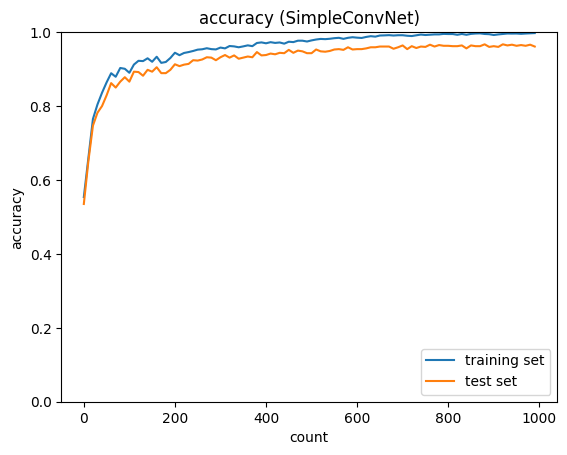

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from tensorflow.keras.datasets import mnist

# データの読み込み
(x_train, d_train), (x_test, d_test) = mnist.load_data()
x_train = x_train.reshape(-1, 1, 28, 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 1, 28, 28).astype('float32') / 255.0

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]

# im2col
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3)
    col = col.reshape(N * out_h * out_w, -1)
    return col

# col2im
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    return img[:, :, pad:H + pad, pad:W + pad]

# Convolutionレイヤ
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        self.x = None
        self.col = None
        self.col_W = None
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = (H + 2 * self.pad - FH) // self.stride + 1
        out_w = (W + 2 * self.pad - FW) // self.stride + 1
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        self.x = x
        self.col = col
        self.col_W = col_W
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

# Poolingレイヤ
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = (H - self.pool_h) // self.stride + 1
        out_w = (W - self.pool_w) // self.stride + 1
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

# ReLU
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout

# Affine
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        return np.dot(x, self.W) + self.b

    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        dx = dx.reshape(*self.original_x_shape)
        return dx

# SoftmaxWithLoss
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        x = x - np.max(x, axis=1, keepdims=True)
        self.y = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        self.loss = -np.sum(np.log(self.y[np.arange(len(t)), t] + 1e-7)) / len(t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx /= batch_size
        return dx

# Adam
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

# SimpleConvNet
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) // filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size // 2) * (conv_output_size // 2))

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1:
            d = np.argmax(d, axis=1)
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td)
        return acc / x.shape[0]

    def gradient(self, x, d):
        self.loss(x, d)
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grad

# 学習
network = SimpleConvNet(input_dim=(1,28,28), conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
optimizer = Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []
plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        print(f'Generation: {i+1}. 正答率(トレーニング) = {accr_train:.4f}')
        print(f'                : {i+1}. 正答率(テスト) = {accr_test:.4f}')

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (SimpleConvNet)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#Section5 最新のCNN

#（パラメータ）正則化
#CIFAR-10 dataset を使用した多値分類分類問題で検証

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


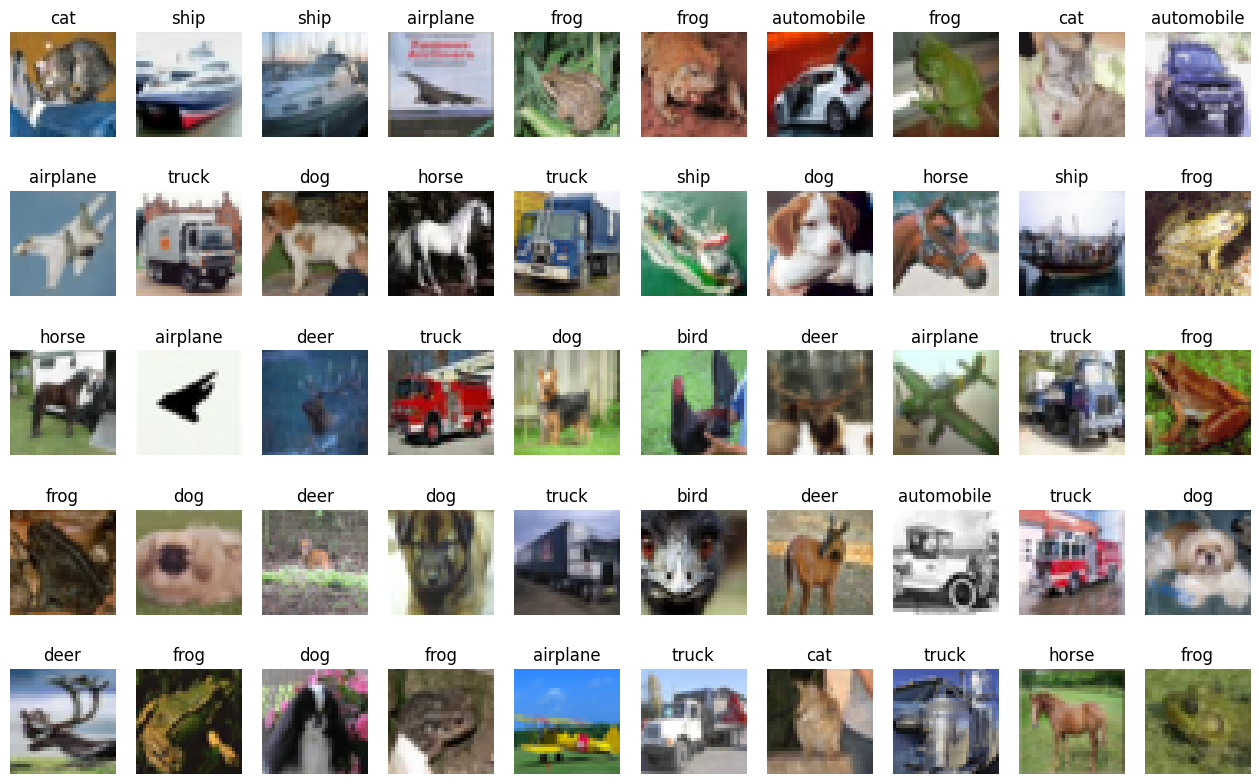

訓練データ形状: (50000, 32, 32, 3)
テストデータ形状: (10000, 32, 32, 3)
ラベル形状: (50000, 10)


In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10データの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 正規化
x_train = x_train / 255
x_test = x_test / 255

# one-hot encoding
y_train = tf.one_hot(y_train.reshape(len(y_train)), depth=10)
y_test = tf.one_hot(y_test.reshape(len(y_test)), depth=10)

# ラベル辞書
index2label = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# 可視化
index = 0
count = 50
plt.figure(figsize=(16, 10))
for i, img in enumerate(x_test[index:index+count]):
    plt.subplot(5, 10, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(index2label[np.argmax(y_test[i])])
plt.show()

print(f"訓練データ形状: {x_train.shape}")  # (50000, 32, 32, 3)
print(f"テストデータ形状: {x_test.shape}")  # (10000, 32, 32, 3)
print(f"ラベル形状: {y_train.shape}")       # (50000, 10)


=== Training with regularizer: None ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 173s 875ms/step - acc: 0.3826 - loss: 1.7319 - val_acc: 0.5658 - val_loss: 1.2507
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 193s 830ms/step - acc: 0.5968 - loss: 1.1510 - val_acc: 0.6207 - val_loss: 1.0928
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 199s 816ms/step - acc: 0.6603 - loss: 0.9754 - val_acc: 0.6573 - val_loss: 0.9910
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 209s 853ms/step - acc: 0.7036 - loss: 0.8461 - val_acc: 0.6763 - val_loss: 0.9427
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 162s 825ms/step - acc: 0.7448 - loss: 0.7369 - val_acc: 0.6773 - val_loss: 0.9580
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 159s 810ms/step - acc: 0.7770 - loss: 0.6494 - val_acc: 0.6780 - val_loss: 0.9773
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 163s 832ms/step - acc: 0.8113 - loss: 0.5515 - val_acc: 0.6799 - val_loss: 0.9976
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 159s 813ms/step - acc: 0.8458 - loss: 0.4623 - val_acc: 0.6699 - val_loss: 1.0822
Epoch 9/10
196/196 ━━━━━

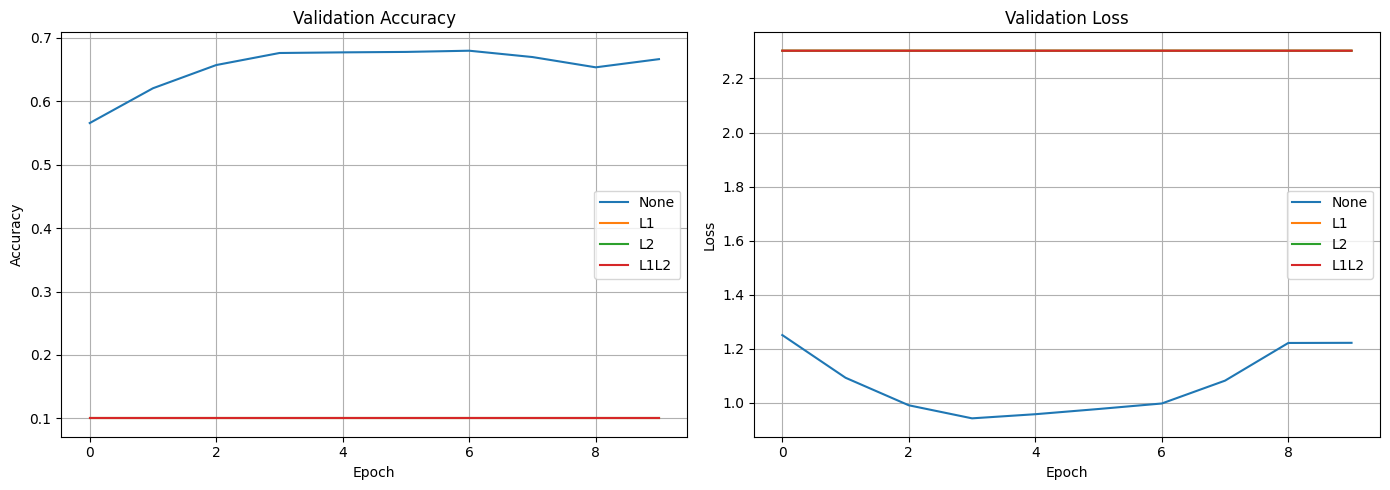


=== 最終結果 ===
None  : Train Acc = 0.8979, Val Acc = 0.6666
L1    : Train Acc = 0.0958, Val Acc = 0.1000
L2    : Train Acc = 0.0958, Val Acc = 0.1000
L1L2  : Train Acc = 0.0958, Val Acc = 0.1000


In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10データの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 正規化
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot encoding
y_train = tf.one_hot(y_train.reshape(len(y_train)), depth=10)
y_test = tf.one_hot(y_test.reshape(len(y_test)), depth=10)

# モデル作成関数
def create_model(input_shape, class_num, regularization_method, regularization_method_weight=0.01):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=input_shape[1:], activation='relu'),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu',
                              activity_regularizer=regularization_method(regularization_method_weight)) if regularization_method else tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(class_num, activation='softmax'),
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

# 学習設定
epochs = 10
batch_size = 256

regularizers = [
    None,
    tf.keras.regularizers.L1,
    tf.keras.regularizers.L2,
    tf.keras.regularizers.L1L2
]

regularizer_names = ['None', 'L1', 'L2', 'L1L2']

tf.random.set_seed(0)

histories = []
for regularizer in regularizers:
    print(f"\n=== Training with regularizer: {regularizer} ===")
    model = create_model(x_train.shape, 10, regularizer)
    history = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size, epochs=epochs,
                        verbose=1)
    histories.append(history)

# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 精度のプロット
for i, history in enumerate(histories):
    axes[0].plot(history.history['val_acc'], label=f'{regularizer_names[i]}')
axes[0].set_title('Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# 損失のプロット
for i, history in enumerate(histories):
    axes[1].plot(history.history['val_loss'], label=f'{regularizer_names[i]}')
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 最終結果の比較
print("\n=== 最終結果 ===")
for i, history in enumerate(histories):
    train_acc = history.history['acc'][-1]
    val_acc = history.history['val_acc'][-1]
    print(f"{regularizer_names[i]:6s}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

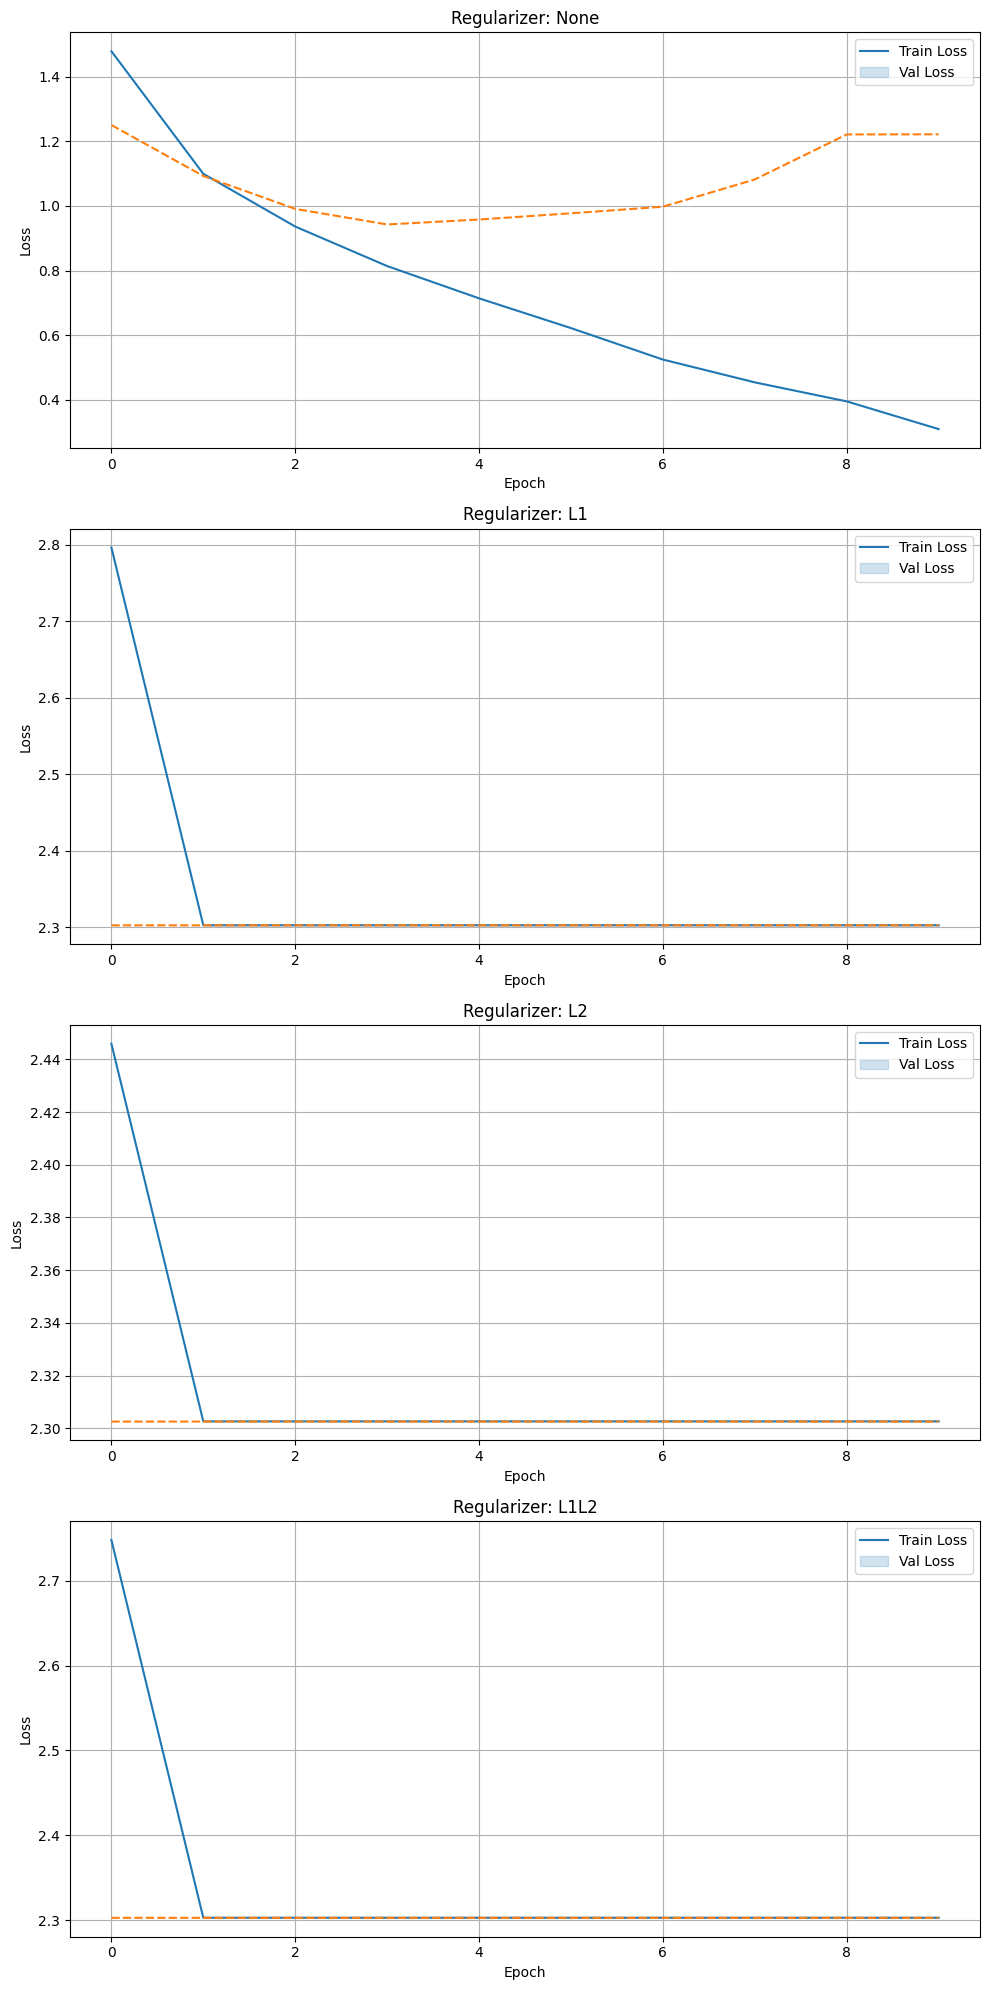

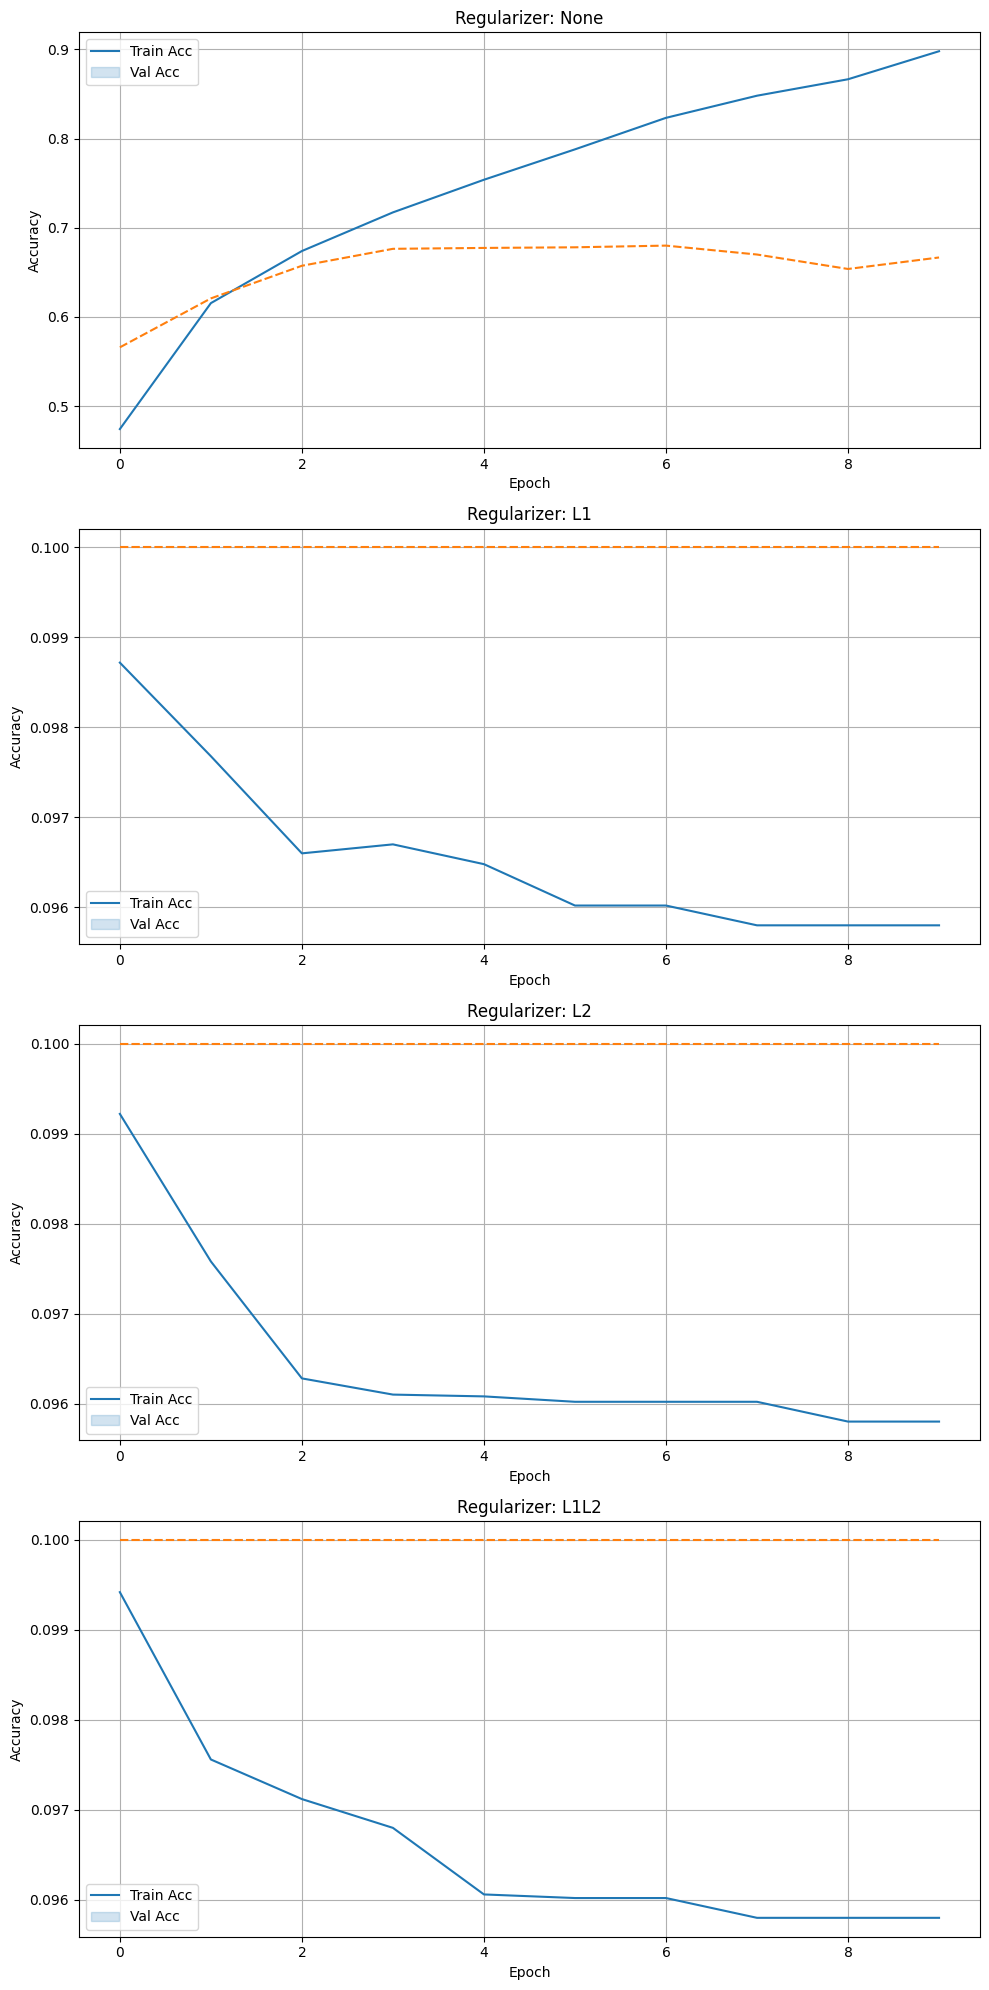


=== 最終結果比較 ===
Regularizer  Train Loss  Val Loss  Train Acc  Val Acc  Overfit Gap
       None    0.308755  1.222042     0.8979   0.6666       0.2313
         L1    2.302666  2.302597     0.0958   0.1000      -0.0042
         L2    2.302665  2.302597     0.0958   0.1000      -0.0042
       L1L2    2.302666  2.302597     0.0958   0.1000      -0.0042


In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 正則化の名前リスト
regularizer_names = ['None', 'L1', 'L2', 'L1L2']

fig = plt.figure(figsize=(10, 20))

for i, history in enumerate(histories):
    ax = fig.add_subplot(4, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['loss', 'val_loss']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Regularizer: {regularizer_names[i]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['Train Loss', 'Val Loss'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 精度も表示
fig2 = plt.figure(figsize=(10, 20))

for i, history in enumerate(histories):
    ax = fig2.add_subplot(4, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['acc', 'val_acc']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Regularizer: {regularizer_names[i]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(['Train Acc', 'Val Acc'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 数値で比較
print("\n=== 最終結果比較 ===")
results = []
for i, history in enumerate(histories):
    results.append({
        'Regularizer': regularizer_names[i],
        'Train Loss': history.history['loss'][-1],
        'Val Loss': history.history['val_loss'][-1],
        'Train Acc': history.history['acc'][-1],
        'Val Acc': history.history['val_acc'][-1],
        'Overfit Gap': history.history['acc'][-1] - history.history['val_acc'][-1]
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

#dropout


=== Training: Without Dropout ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 172s 863ms/step - acc: 0.3251 - loss: 1.9127 - val_acc: 0.5438 - val_loss: 1.3045
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 155s 790ms/step - acc: 0.5612 - loss: 1.2410 - val_acc: 0.6140 - val_loss: 1.1094
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 158s 809ms/step - acc: 0.6432 - loss: 1.0138 - val_acc: 0.6448 - val_loss: 1.0069
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 210s 848ms/step - acc: 0.6949 - loss: 0.8697 - val_acc: 0.6663 - val_loss: 0.9494
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 161s 822ms/step - acc: 0.7332 - loss: 0.7693 - val_acc: 0.6832 - val_loss: 0.9372
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 157s 804ms/step - acc: 0.7686 - loss: 0.6673 - val_acc: 0.6807 - val_loss: 0.9834
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 206s 826ms/step - acc: 0.8068 - loss: 0.5679 - val_acc: 0.6821 - val_loss: 1.0279
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 199s 810ms/step - acc: 0.8319 - loss: 0.4909 - val_acc: 0.6507 - val_loss: 1.1989
Epoch 9/10
196/196 ━━━━━

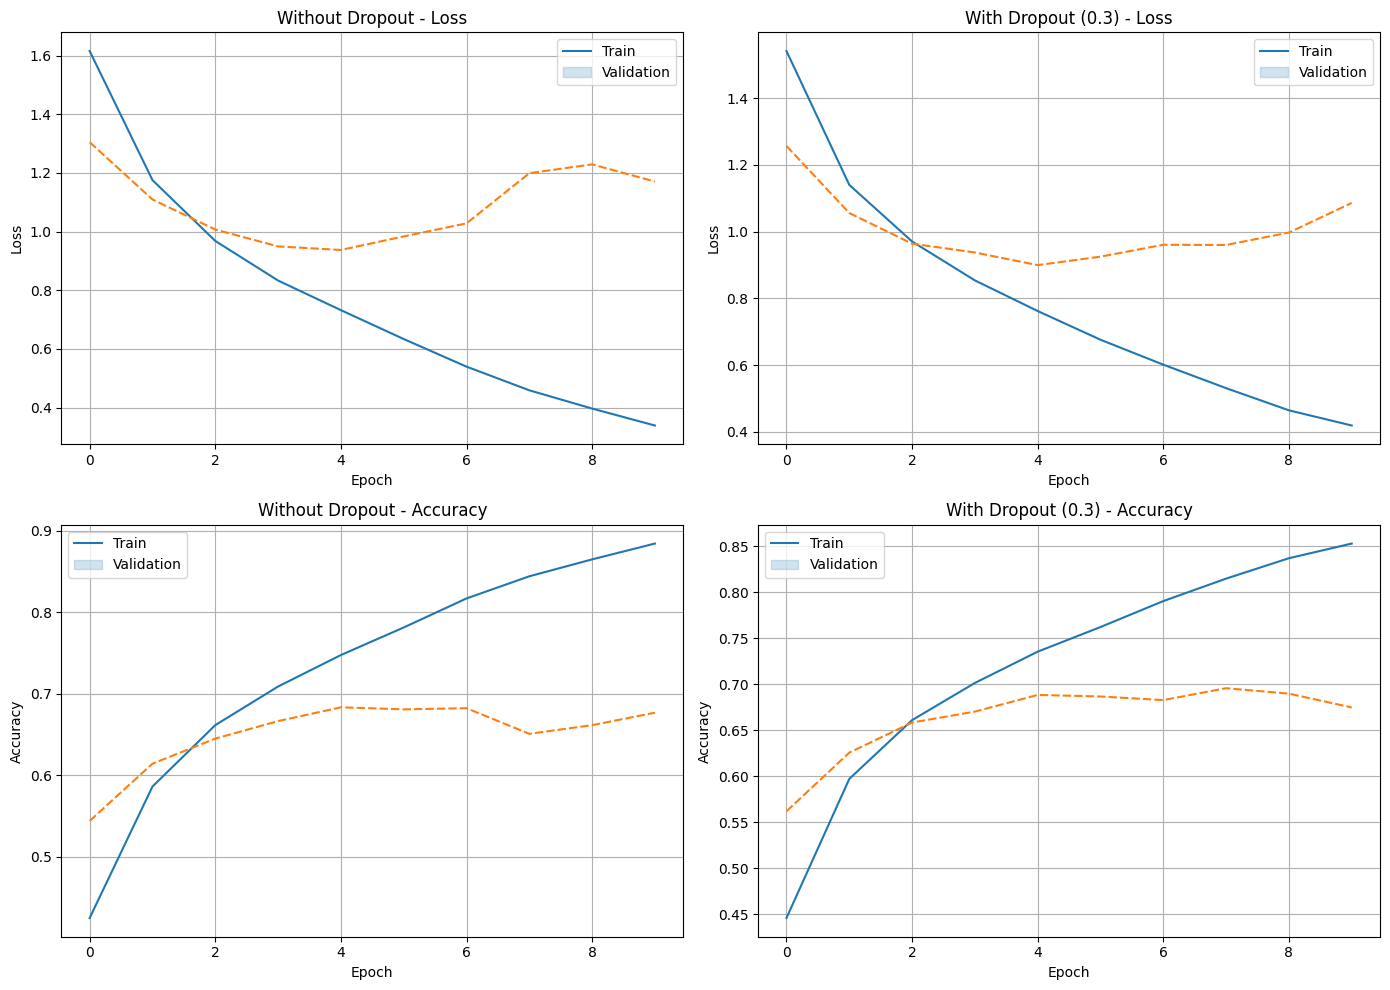


=== 最終結果比較 ===
             Model Train Loss Val Loss Train Acc Val Acc Overfit Gap
   Without Dropout     0.3390   1.1703    0.8842  0.6766      0.2076
With Dropout (0.3)     0.4187   1.0861    0.8530  0.6749      0.1781


In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# CIFAR-10データの読み込み（まだ読み込んでいない場合）
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.one_hot(y_train.reshape(len(y_train)), depth=10)
y_test = tf.one_hot(y_test.reshape(len(y_test)), depth=10)

# モデル作成関数
def create_model(input_shape, class_num, is_use_dropout, dropout_rate=0.1):
    if is_use_dropout:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=input_shape[1:], activation='relu'),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(class_num, activation='softmax'),
        ])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=input_shape[1:], activation='relu'),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(class_num, activation='softmax'),
        ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

# 学習設定
epochs = 10
batch_size = 256

is_use_dropouts = [False, True]
dropout_names = ['Without Dropout', 'With Dropout (0.3)']

tf.random.set_seed(0)

histories = []
for is_use_dropout in is_use_dropouts:
    print(f"\n=== Training: {'With' if is_use_dropout else 'Without'} Dropout ===")
    model = create_model(x_train.shape, 10, is_use_dropout, 0.3)
    history = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size, epochs=epochs,
                        verbose=1)
    histories.append(history)

# 結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, history in enumerate(histories):
    # Loss
    ax = axes[0, i]
    plot_df = pd.DataFrame(history.history)[['loss', 'val_loss']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'{dropout_names[i]} - Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['Train', 'Validation'])
    ax.grid(True)

    # Accuracy
    ax = axes[1, i]
    plot_df = pd.DataFrame(history.history)[['acc', 'val_acc']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'{dropout_names[i]} - Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(['Train', 'Validation'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 数値比較
print("\n=== 最終結果比較 ===")
results = []
for i, history in enumerate(histories):
    results.append({
        'Model': dropout_names[i],
        'Train Loss': f"{history.history['loss'][-1]:.4f}",
        'Val Loss': f"{history.history['val_loss'][-1]:.4f}",
        'Train Acc': f"{history.history['acc'][-1]:.4f}",
        'Val Acc': f"{history.history['val_acc'][-1]:.4f}",
        'Overfit Gap': f"{history.history['acc'][-1] - history.history['val_acc'][-1]:.4f}"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

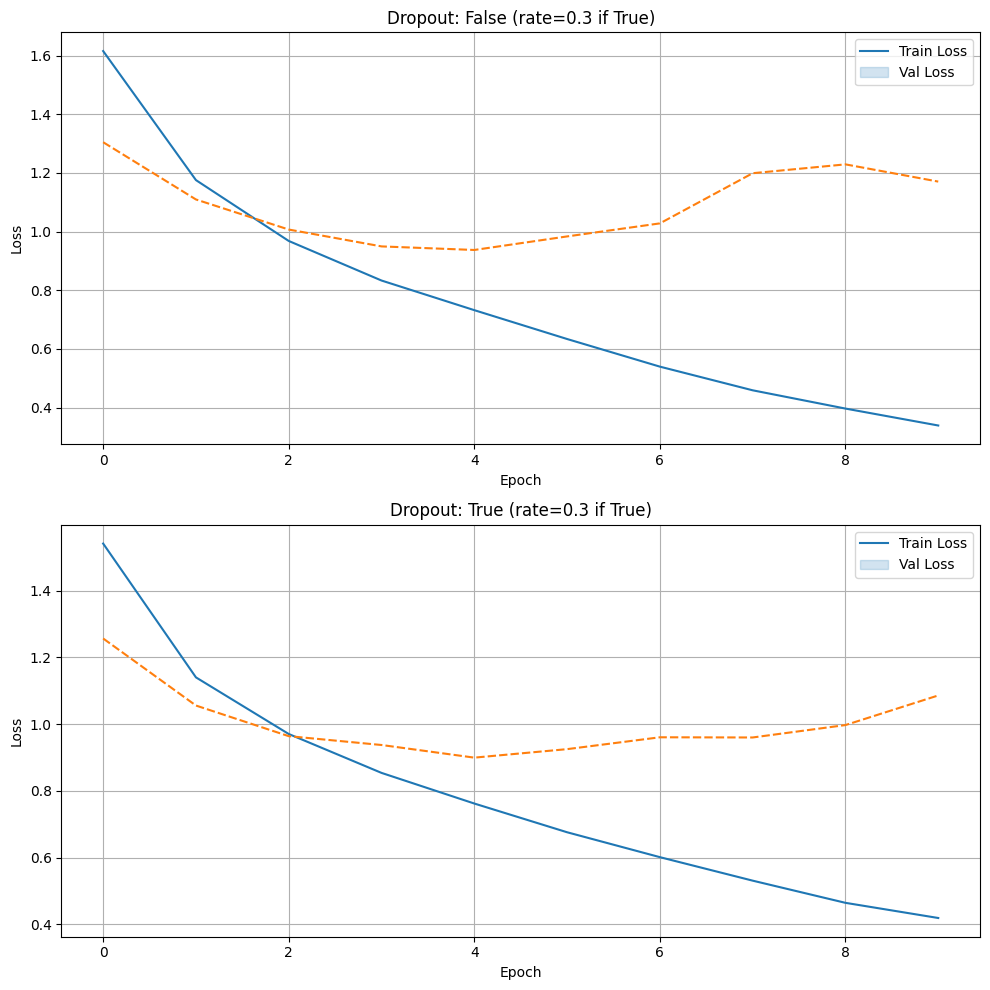

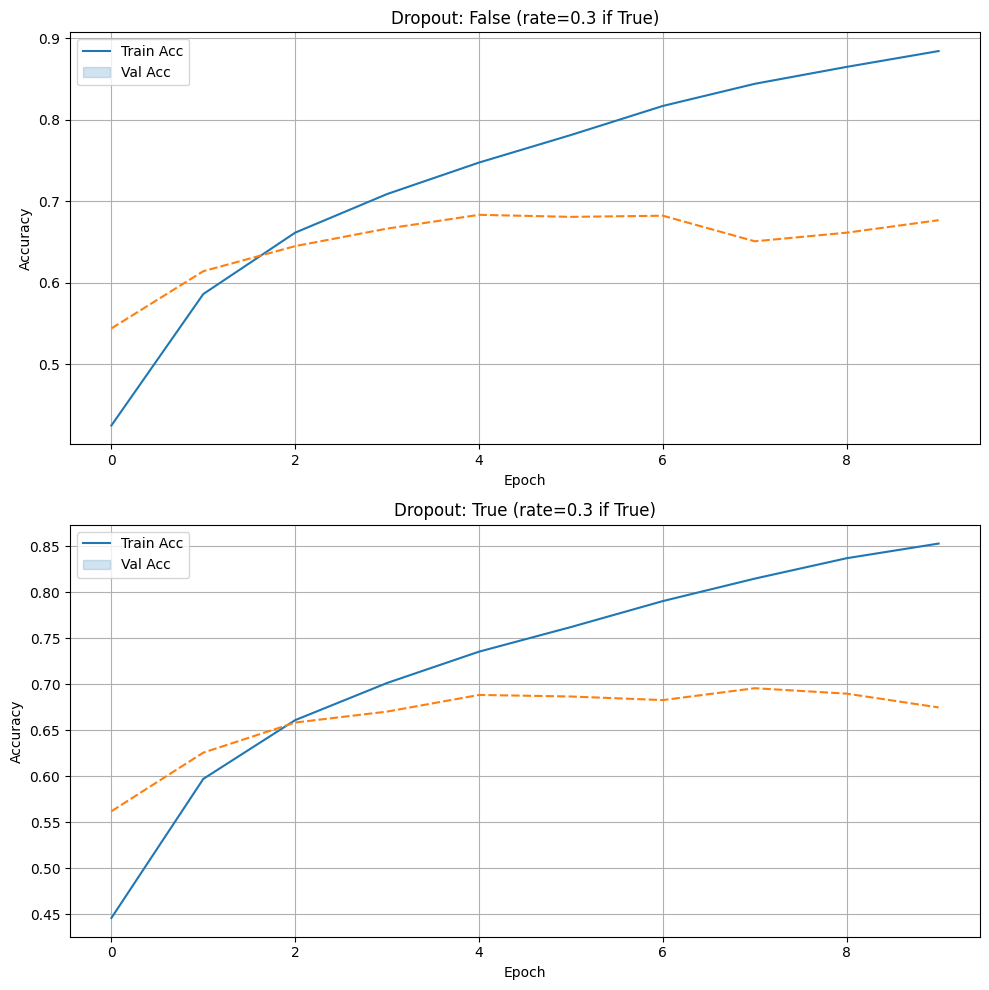


=== Dropout効果の比較 ===
Dropout=False: Train Acc=0.8842, Val Acc=0.6766, Gap=0.2076
Dropout=True : Train Acc=0.8530, Val Acc=0.6749, Gap=0.1781


In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

for i, history in enumerate(histories):
    ax = fig.add_subplot(2, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['loss', 'val_loss']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Dropout: {is_use_dropouts[i]} (rate=0.3 if True)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['Train Loss', 'Val Loss'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 精度も表示
fig2 = plt.figure(figsize=(10, 10))

for i, history in enumerate(histories):
    ax = fig2.add_subplot(2, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['acc', 'val_acc']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Dropout: {is_use_dropouts[i]} (rate=0.3 if True)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(['Train Acc', 'Val Acc'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 数値比較
print("\n=== Dropout効果の比較 ===")
for i, history in enumerate(histories):
    train_acc = history.history['acc'][-1]
    val_acc = history.history['val_acc'][-1]
    gap = train_acc - val_acc
    print(f"Dropout={str(is_use_dropouts[i]):5s}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Gap={gap:.4f}")

#layer-nomalization

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# CIFAR-10データの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.one_hot(y_train.reshape(len(y_train)), depth=10)
y_test = tf.one_hot(y_test.reshape(len(y_test)), depth=10)

# InstanceNormalizationを自作
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=(input_shape[-1],),
                                     initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(input_shape[-1],),
                                    initializer='zeros', trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(variance + self.epsilon) + self.beta

# モデル作成関数
def create_model(input_shape, class_num, norm_layer):
    if norm_layer:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=input_shape[1:], activation='relu'),
            norm_layer(),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(class_num, activation='softmax'),
        ])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=input_shape[1:], activation='relu'),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(class_num, activation='softmax'),
        ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

# 学習設定
epochs = 10
batch_size = 256

norm_layers = [
    None,
    tf.keras.layers.BatchNormalization,
    tf.keras.layers.LayerNormalization,
    InstanceNormalization
]

norm_names = ['None', 'BatchNorm', 'LayerNorm', 'InstanceNorm']

tf.random.set_seed(0)

histories = []
for i, norm_layer in enumerate(norm_layers):
    print(f"\n=== Training with: {norm_names[i]} ===")
    model = create_model(x_train.shape, 10, norm_layer)
    history = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size, epochs=epochs,
                        verbose=1)
    histories.append(history)

# 結果の可視化
fig = plt.figure(figsize=(10, 20))

for i, history in enumerate(histories):
    ax = fig.add_subplot(4, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['loss', 'val_loss']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Normalization: {norm_names[i]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['Train Loss', 'Val Loss'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 数値比較
print("\n=== 最終結果比較 ===")
for i, history in enumerate(histories):
    train_acc = history.history['acc'][-1]
    val_acc = history.history['val_acc'][-1]
    print(f"{norm_names[i]:15s}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


=== Training with: None ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
 67/196 ━━━━━━━━━━━━━━━━━━━━ 1:40 777ms/step - acc: 0.2407 - loss: 2.1276

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# CIFAR-10データの読み込み（まだ読み込んでいない場合）
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.one_hot(y_train.reshape(len(y_train)), depth=10)
y_test = tf.one_hot(y_test.reshape(len(y_test)), depth=10)

# モデル作成関数
def create_model(input_shape, class_num, norm_layer):
    if norm_layer:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=input_shape[1:], activation='relu'),
            norm_layer(),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(class_num, activation='softmax'),
        ])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=input_shape[1:], activation='relu'),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(class_num, activation='softmax'),
        ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

# 学習設定
epochs = 10
batch_size = 256

norm_layers = [
    None,
    tf.keras.layers.BatchNormalization,
    tf.keras.layers.LayerNormalization,
    tfa.layers.InstanceNormalization
]

norm_names = ['None', 'BatchNorm', 'LayerNorm', 'InstanceNorm']

tf.random.set_seed(0)

histories = []
for i, norm_layer in enumerate(norm_layers):
    print(f"\n=== Training with: {norm_names[i]} ===")
    model = create_model(x_train.shape, 10, norm_layer)
    history = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size, epochs=epochs,
                        verbose=1)
    histories.append(history)

# 結果の可視化
fig = plt.figure(figsize=(12, 16))

for i, history in enumerate(histories):
    ax = fig.add_subplot(4, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['loss', 'val_loss']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Normalization: {norm_names[i]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['Train Loss', 'Val Loss'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 精度の比較
fig2 = plt.figure(figsize=(12, 16))

for i, history in enumerate(histories):
    ax = fig2.add_subplot(4, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['acc', 'val_acc']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Normalization: {norm_names[i]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(['Train Acc', 'Val Acc'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 数値比較
print("\n=== 最終結果比較 ===")
results = []
for i, history in enumerate(histories):
    results.append({
        'Normalization': norm_names[i],
        'Train Acc': f"{history.history['acc'][-1]:.4f}",
        'Val Acc': f"{history.history['val_acc'][-1]:.4f}",
        'Train Loss': f"{history.history['loss'][-1]:.4f}",
        'Val Loss': f"{history.history['val_loss'][-1]:.4f}"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 正規化層の名前リスト
norm_names = ['None', 'BatchNormalization', 'LayerNormalization', 'InstanceNormalization']

fig = plt.figure(figsize=(10, 20))

for i, history in enumerate(histories):
    ax = fig.add_subplot(4, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['loss', 'val_loss']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Normalization: {norm_names[i]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['Train Loss', 'Val Loss'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 精度も表示
fig2 = plt.figure(figsize=(10, 20))

for i, history in enumerate(histories):
    ax = fig2.add_subplot(4, 1, i + 1)
    plot_df = pd.DataFrame(history.history)[['acc', 'val_acc']]
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_title(f'Normalization: {norm_names[i]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(['Train Acc', 'Val Acc'])
    ax.grid(True)

plt.tight_layout()
plt.show()

# 数値比較
print("\n=== 正規化層の効果比較 ===")
for i, history in enumerate(histories):
    train_acc = history.history['acc'][-1]
    val_acc = history.history['val_acc'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    print(f"{norm_names[i]:25s}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Loss={val_loss:.4f}")